In [324]:
import numpy as np 
import pandas as pd 
import json 
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

import requests 
from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes #
import folium 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

print('Libraries imported!')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.1
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.1
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Libraries imported!


In [325]:
counties = pd.read_csv('PortugalCounties.csv')
counties.head()

,city,lat,lng,country,iso2,admin,capital,population,population_proper
0,Lisbon,38.716667,-9.133333,Portugal,PT,Lisboa,primary,2812000.0,517802.0
1,Picotos,41.192402,-8.619816,Portugal,PT,Porto,NaN,1337000.0,249633.0
2,Braga,41.550323,-8.420052,Portugal,PT,Braga,admin,826833.0,181819.0
3,Funchal,32.633333,-16.900000,Portugal,PT,Madeira,admin,204767.0,100847.0
4,Setúbal,38.533333,-8.900000,Portugal,PT,Setúbal,admin,117974.0,117110.0


In [326]:
counties = counties[counties['admin'] == "Lisboa"]
counties = counties[['city','lat','lng']]
counties.rename(columns={'city': 'City', 'lat': 'Latitude', 'lng': 'Longitude'}, inplace=True)
counties.reset_index(drop=True, inplace=True)
counties.head(20)

,City,Latitude,Longitude
0,Lisbon,38.716667,-9.133333
1,Sobral de Monte Agraço,39.019579,-9.150809
2,Mafra,38.937933,-9.327565
3,Amadora,38.759711,-9.239708
4,Lourinhã,39.233333,-9.316667
5,Sintra,38.800971,-9.378257
6,Oeiras,38.691049,-9.310847
7,Torres Vedras,39.091089,-9.258602
8,Azambuja,39.070290,-8.868220
9,Alenquer,39.053151,-9.009282


In [327]:
latitude = counties['Latitude'].iloc[0]
longitude = counties['Longitude'].iloc[0]

In [328]:
map_lisbon = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, county in zip(counties['Latitude'], counties['Longitude'], counties['City']):
    label = '{}'.format(county)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lisbon)  
    
map_lisbon

In [330]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [331]:
lisbon_venues = getNearbyVenues(names=counties['City'], latitudes=counties['Latitude'], longitudes=counties['Longitude'])

Lisbon
Sobral de Monte Agraço
Mafra
Amadora
Lourinhã
Sintra
Oeiras
Torres Vedras
Azambuja
Alenquer
Cascais
Odivelas
Arruda dos Vinhos
Vila Franca de Xira
Cadaval
Loures


In [332]:
print(lisbon_venues.shape)
lisbon_venues.head()

(355, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lisbon,38.716667,-9.133333,Miradouro Sophia de Mello Breyner Andresen,38.716454,-9.131557,Scenic Lookout
1,Lisbon,38.716667,-9.133333,Café da Garagem,38.714806,-9.132889,Café
2,Lisbon,38.716667,-9.133333,Teatro Taborda,38.715129,-9.132955,Theater
3,Lisbon,38.716667,-9.133333,The Food Temple,38.715881,-9.134385,Vegetarian / Vegan Restaurant
4,Lisbon,38.716667,-9.133333,Jardim da Cerca da Graça,38.717911,-9.132196,Garden


In [333]:
restaurants = lisbon_venues[lisbon_venues['Venue Category'].str.contains("Restaurant")]
restaurants = restaurants[restaurants['Venue Category'] != 'Restaurant']
restaurants.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
3,Lisbon,38.716667,-9.133333,The Food Temple,38.715881,-9.134385,Vegetarian / Vegan Restaurant
5,Lisbon,38.716667,-9.133333,Zé da Mouraria,38.716170,-9.134833,Portuguese Restaurant
12,Lisbon,38.716667,-9.133333,Chinês Clandestino,38.717378,-9.134961,Chinese Restaurant
16,Lisbon,38.716667,-9.133333,Maria da Mouraria,38.716218,-9.134614,Portuguese Restaurant
22,Lisbon,38.716667,-9.133333,Trigueirinho,38.713900,-9.135771,Portuguese Restaurant


In [334]:
restaurants_dummies = restaurants.set_index('City')
restaurants_dummies =  pd.get_dummies(restaurants_dummies[['Venue Category']], prefix="", prefix_sep="")
restaurants_dummies.reset_index(level=0, inplace=True)
restaurants_dummies

,City,African Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Empanada Restaurant,Fast Food Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Mediterranean Restaurant,Modern European Restaurant,Portuguese Restaurant,Seafood Restaurant,Sushi Restaurant,Tapas Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Lisbon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,Lisbon,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,Lisbon,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Lisbon,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,Lisbon,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,Vila Franca de Xira,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
87,Vila Franca de Xira,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
88,Vila Franca de Xira,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
89,Cadaval,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


# Média

In [335]:
restaurants_mean = restaurants_dummies.groupby('City').mean()
restaurants_mean.reset_index(level=0, inplace=True)
restaurants_mean

,City,African Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Empanada Restaurant,Fast Food Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Mediterranean Restaurant,Modern European Restaurant,Portuguese Restaurant,Seafood Restaurant,Sushi Restaurant,Tapas Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Alenquer,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Amadora,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.0,0.500000,0.000000,0.125000,0.125000,0.000000,0.000000
2,Arruda dos Vinhos,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Azambuja,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Cadaval,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Cascais,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.190476,0.095238,0.000000,0.000000,0.0,0.333333,0.095238,0.142857,0.095238,0.047619,0.000000
6,Lisbon,0.041667,0.000000,0.041667,0.083333,0.041667,0.00,0.208333,0.000000,0.000000,0.041667,0.0,0.375000,0.041667,0.000000,0.000000,0.083333,0.041667
7,Loures,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Mafra,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.833333,0.000000,0.166667,0.000000,0.000000,0.000000
9,Odivelas,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.200000,0.000000,0.000000,0.0,0.600000,0.200000,0.000000,0.000000,0.000000,0.000000


In [336]:
restaurants_mean.shape

(15, 18)

In [337]:
num_top_venues = 5

for county in restaurants_mean['City']:
    print("---- " + county + " ----")
    temp = restaurants_mean[restaurants_mean['City'] == county].T.reset_index()
    temp.columns = ['Venue','Freq.']
    temp = temp.iloc[1:]
    temp['Freq.'] = temp['Freq.'].astype(float)
    temp = temp.round({'Freq.': 2})
    print(temp.sort_values('Freq.', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Alenquer ----
                           Venue  Freq.
0     Modern European Restaurant    1.0
1             African Restaurant    0.0
2       Mediterranean Restaurant    0.0
3  Vegetarian / Vegan Restaurant    0.0
4               Tapas Restaurant    0.0


---- Amadora ----
                   Venue  Freq.
0  Portuguese Restaurant   0.50
1   Fast Food Restaurant   0.25
2       Tapas Restaurant   0.12
3       Sushi Restaurant   0.12
4     African Restaurant   0.00


---- Arruda dos Vinhos ----
                           Venue  Freq.
0          Portuguese Restaurant    1.0
1             African Restaurant    0.0
2       Mediterranean Restaurant    0.0
3  Vegetarian / Vegan Restaurant    0.0
4               Tapas Restaurant    0.0


---- Azambuja ----
                           Venue  Freq.
0          Portuguese Restaurant    1.0
1             African Restaurant    0.0
2       Mediterranean Restaurant    0.0
3  Vegetarian / Vegan Restaurant    0.0
4               Tapas Restaurant    0.

# TOP Cuisines

In [338]:
restaurants_mean.mean().sort_values(ascending = False)

Portuguese Restaurant            0.639074
Sushi Restaurant                 0.077116
Modern European Restaurant       0.066667
Tapas Restaurant                 0.059127
Seafood Restaurant               0.040979
Indian Restaurant                0.026587
Italian Restaurant               0.019683
Fast Food Restaurant             0.016667
Asian Restaurant                 0.014815
Japanese Restaurant              0.011111
Vegetarian / Vegan Restaurant    0.008730
Chinese Restaurant               0.005556
Brazilian Restaurant             0.002778
Vietnamese Restaurant            0.002778
Empanada Restaurant              0.002778
Mediterranean Restaurant         0.002778
African Restaurant               0.002778
dtype: float64

<AxesSubplot:>

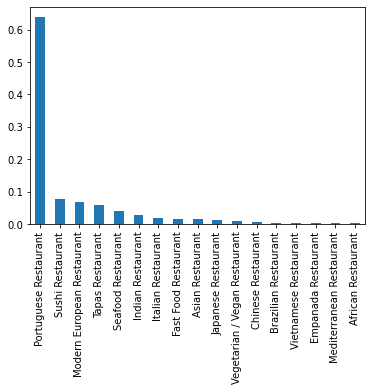

In [419]:
restaurants_mean.mean().sort_values(ascending = False).plot(kind='bar')

# Variety for each county

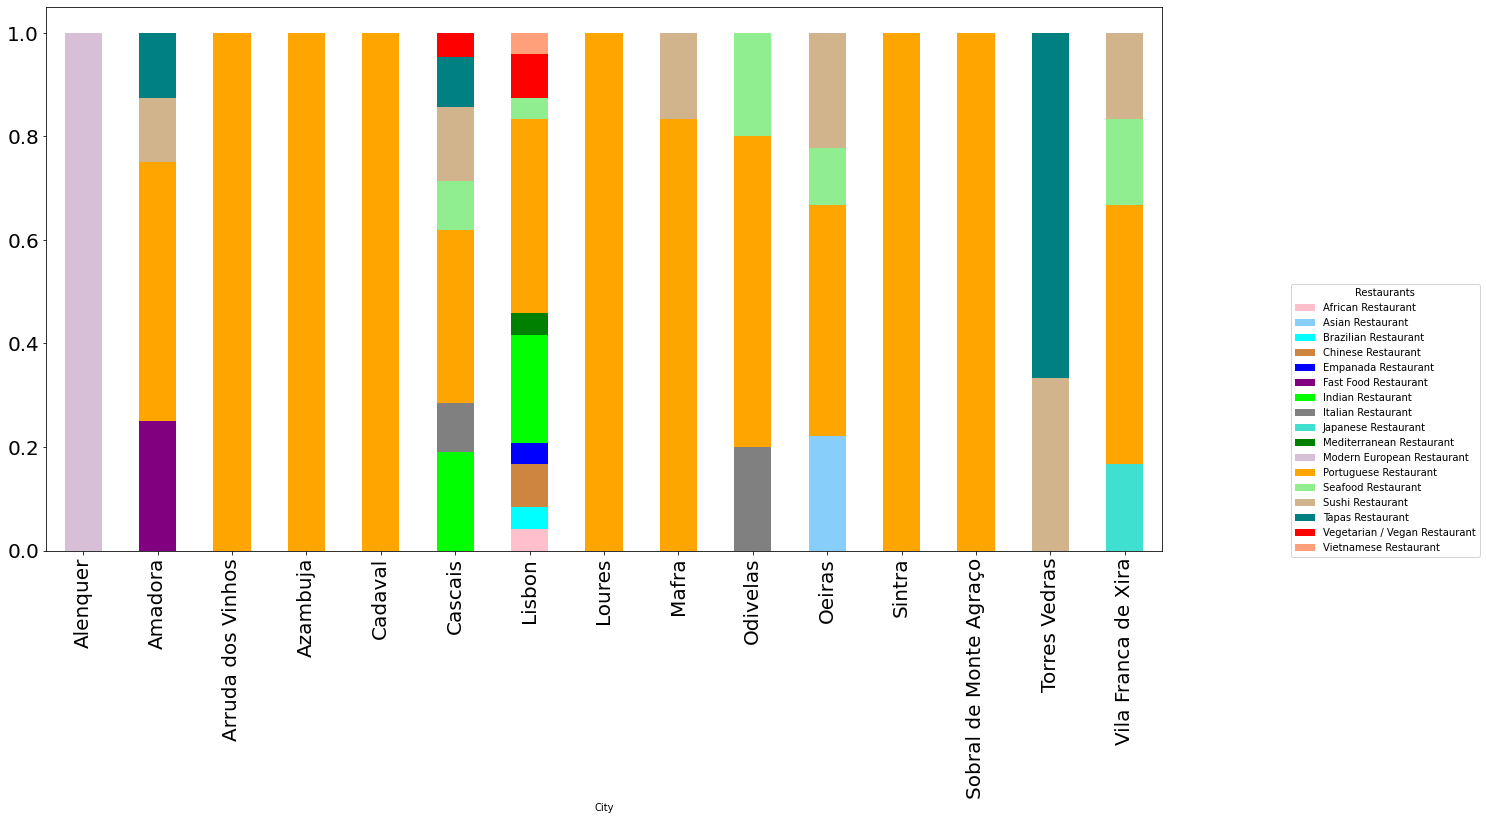

In [340]:
restaurants_mean_temp = restaurants_mean.set_index('City')
restaurants_mean_temp.plot(kind='bar',stacked=True, fontsize = 20, figsize=(20,10), color={"red","green", "orange", "blue", "pink", "purple", "lightskyblue", "lightsalmon", "lightgreen", "turquoise", "cyan", "grey", "tan", "teal", "lime", "thistle", "peru"}).legend(
    loc='upper center', ncol=1, title="Restaurants", bbox_to_anchor=(1.2, 0.5))

# Density

In [341]:
lisbon_population = pd.read_csv('lisbon_population.csv')
lisbon_population_merged = pd.merge(counties, lisbon_population, left_on='City', right_on='City', how='left')

lisbon_population_temp = lisbon_population_merged
lisbon_population_temp = lisbon_population_temp.sort_values('City')
lisbon_population_temp = lisbon_population_temp.set_index('City')
lisbon_population_temp = lisbon_population_temp.drop(columns = ['Latitude','Longitude'])
lisbon_population_temp.head()

,Population
City,
Alenquer,43596
Amadora,181724
Arruda dos Vinhos,15082
Azambuja,22445
Cadaval,13627


In [342]:
restaurants_temp = restaurants
restaurants_temp = restaurants_temp.sort_values('City')
restaurants_temp = restaurants_temp.groupby(['City']).count()
restaurants_temp = restaurants_temp.drop(columns = ['City Latitude','City Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude'])
restaurants_temp.rename(columns={'Venue Category': 'Venues Total'}, inplace=True)
restaurants_temp.head()

,Venues Total
City,
Alenquer,1
Amadora,8
Arruda dos Vinhos,3
Azambuja,1
Cadaval,1


<AxesSubplot:xlabel='City'>

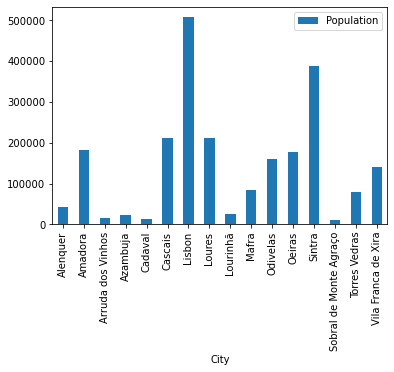

In [343]:
lisbon_population_temp.plot(kind='bar')

<AxesSubplot:xlabel='City'>

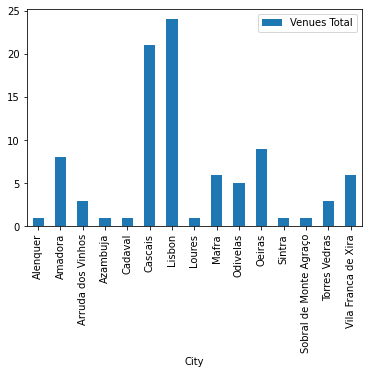

In [344]:
restaurants_temp.plot(kind='bar')

In [345]:
competitiveness = pd.merge(restaurants_temp, lisbon_population_temp, left_index=True, right_index=True)
#competitiveness['Venues Total'] = competitiveness['Venues Total'] * 20000
competitiveness['Difference'] = competitiveness['Population'] / competitiveness['Venues Total']
competitiveness = competitiveness.drop(columns = ['Venues Total', 'Population'])
competitiveness = competitiveness.sort_values('Difference')
competitiveness

,Difference
City,
Arruda dos Vinhos,5027.333333
Cascais,10117.809524
Sobral de Monte Agraço,10490.000000
Cadaval,13627.000000
Mafra,14001.333333
Oeiras,19579.777778
Lisbon,21134.166667
Azambuja,22445.000000
Amadora,22715.500000


<AxesSubplot:xlabel='City'>

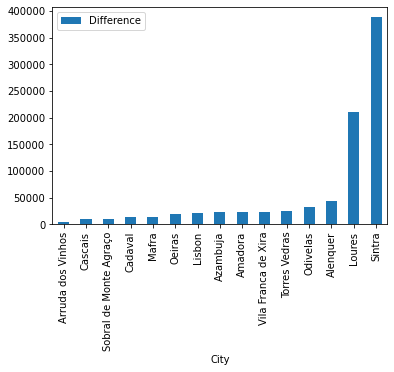

In [346]:
competitiveness.plot(kind='bar')

In [347]:
map_restaurants = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, category in zip(restaurants['Venue Latitude'], restaurants['Venue Longitude'], restaurants['Venue Category']):
    label = '{}'.format(category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_restaurants)  
    
map_restaurants

# Clustering

#### Best number of clusters

In [348]:
from sklearn.preprocessing import MinMaxScaler

In [392]:
mms = MinMaxScaler()
mms.fit(restaurants_mean.drop('City', 1))
data_transformed = mms.transform(restaurants_mean.drop('City', 1))

In [393]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (13). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (14). Possibly due to duplicate points in X.
  return_n_iter=True)


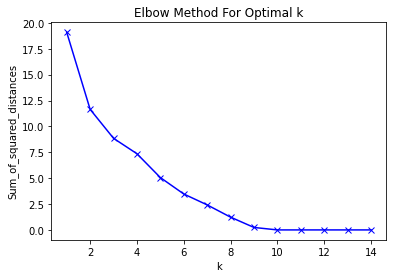

In [394]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### Clustering into cuisine groups

In [395]:
kclusters = 9

restaurants_mean_clustering = restaurants_mean.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(restaurants_mean_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 7, 5, 5, 5, 2, 2, 5, 1, 4], dtype=int32)

In [396]:
num_top_venues = 5

def MostFrequentCuisines(cluster):
    for county in cluster['City']:
        print("---- " + county + " ----")
        temp = cluster[cluster['City'] == county].T.reset_index()
        temp.columns = ['Venue','Freq.']
        temp = temp.iloc[1:]
        temp['Freq.'] = temp['Freq.'].astype(float)
        temp = temp.round({'Freq.': 2})
        print(temp.sort_values('Freq.', ascending=False).reset_index(drop=True).head(num_top_venues))
        print('\n')

In [397]:
counties_cluster = counties[counties['City'] != 'Lourinhã']
restaurants_mean_cluster = restaurants_mean

In [398]:
counties_cluster.insert(0, 'Cluster', kmeans.labels_)

In [399]:
restaurants_mean_merged = restaurants_mean_cluster.join(counties_cluster.set_index('City'), on='City')
restaurants_mean_merged = restaurants_mean_merged.drop(columns = ['Latitude','Longitude'])
restaurants_mean_merged.head() 

,City,African Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Empanada Restaurant,Fast Food Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Mediterranean Restaurant,Modern European Restaurant,Portuguese Restaurant,Seafood Restaurant,Sushi Restaurant,Tapas Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Cluster
0,Alenquer,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000,0.000,0.0,0.0,1
1,Amadora,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.125,0.125,0.0,0.0,5
2,Arruda dos Vinhos,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000,0.000,0.0,0.0,5
3,Azambuja,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000,0.000,0.0,0.0,5
4,Cadaval,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000,0.000,0.0,0.0,3


# Cluster 1

In [400]:
cluster_0 = restaurants_mean_merged.loc[restaurants_mean_merged['Cluster'] == 0]
cluster_0 = cluster_0.drop(columns = ['Cluster'])

In [401]:
MostFrequentCuisines(cluster_0)

---- Lisbon ----
                           Venue  Freq.
0          Portuguese Restaurant   0.38
1              Indian Restaurant   0.21
2  Vegetarian / Vegan Restaurant   0.08
3             Chinese Restaurant   0.08
4             African Restaurant   0.04




# Cluster 2

In [402]:
cluster_1 = restaurants_mean_merged.loc[restaurants_mean_merged['Cluster'] == 1]
cluster_1 = cluster_1.drop(columns = ['Cluster'])

In [403]:
MostFrequentCuisines(cluster_1)

---- Alenquer ----
                           Venue  Freq.
0     Modern European Restaurant    1.0
1             African Restaurant    0.0
2       Mediterranean Restaurant    0.0
3  Vegetarian / Vegan Restaurant    0.0
4               Tapas Restaurant    0.0




# Cluster 3

In [404]:
cluster_2 = restaurants_mean_merged.loc[restaurants_mean_merged['Cluster'] == 2]
cluster_2 = cluster_2.drop(columns = ['Cluster'])

In [405]:
MostFrequentCuisines(cluster_2)

---- Oeiras ----
                   Venue  Freq.
0  Portuguese Restaurant   0.44
1       Sushi Restaurant   0.22
2       Asian Restaurant   0.22
3     Seafood Restaurant   0.11
4     African Restaurant   0.00


---- Torres Vedras ----
                           Venue  Freq.
0               Tapas Restaurant   0.67
1               Sushi Restaurant   0.33
2             African Restaurant   0.00
3       Mediterranean Restaurant   0.00
4  Vegetarian / Vegan Restaurant   0.00




# Cluster 4

In [406]:
cluster_3 = restaurants_mean_merged.loc[restaurants_mean_merged['Cluster'] == 3]
cluster_3 = cluster_3.drop(columns = ['Cluster'])

In [407]:
MostFrequentCuisines(cluster_3)

---- Cadaval ----
                           Venue  Freq.
0          Portuguese Restaurant    1.0
1             African Restaurant    0.0
2       Mediterranean Restaurant    0.0
3  Vegetarian / Vegan Restaurant    0.0
4               Tapas Restaurant    0.0




# Cluster 5

In [408]:
cluster_4 = restaurants_mean_merged.loc[restaurants_mean_merged['Cluster'] == 4]
cluster_4 = cluster_4.drop(columns = ['Cluster'])

In [409]:
MostFrequentCuisines(cluster_4)

---- Cascais ----
                   Venue  Freq.
0  Portuguese Restaurant   0.33
1      Indian Restaurant   0.19
2       Sushi Restaurant   0.14
3       Tapas Restaurant   0.10
4     Seafood Restaurant   0.10




# Cluster 6

In [410]:
cluster_5 = restaurants_mean_merged.loc[restaurants_mean_merged['Cluster'] == 5]
cluster_5 = cluster_5.drop(columns = ['Cluster'])

In [411]:
MostFrequentCuisines(cluster_5)

---- Amadora ----
                   Venue  Freq.
0  Portuguese Restaurant   0.50
1   Fast Food Restaurant   0.25
2       Tapas Restaurant   0.12
3       Sushi Restaurant   0.12
4     African Restaurant   0.00


---- Arruda dos Vinhos ----
                           Venue  Freq.
0          Portuguese Restaurant    1.0
1             African Restaurant    0.0
2       Mediterranean Restaurant    0.0
3  Vegetarian / Vegan Restaurant    0.0
4               Tapas Restaurant    0.0


---- Azambuja ----
                           Venue  Freq.
0          Portuguese Restaurant    1.0
1             African Restaurant    0.0
2       Mediterranean Restaurant    0.0
3  Vegetarian / Vegan Restaurant    0.0
4               Tapas Restaurant    0.0


---- Mafra ----
                           Venue  Freq.
0          Portuguese Restaurant   0.83
1               Sushi Restaurant   0.17
2             African Restaurant   0.00
3       Mediterranean Restaurant   0.00
4  Vegetarian / Vegan Restaurant   0.00



# Cluster 7

In [412]:
cluster_6 = restaurants_mean_merged.loc[restaurants_mean_merged['Cluster'] == 6]
cluster_6 = cluster_6.drop(columns = ['Cluster'])

In [413]:
MostFrequentCuisines(cluster_6)

---- Loures ----
                           Venue  Freq.
0          Portuguese Restaurant    1.0
1             African Restaurant    0.0
2       Mediterranean Restaurant    0.0
3  Vegetarian / Vegan Restaurant    0.0
4               Tapas Restaurant    0.0




# Cluster 8

In [414]:
cluster_7 = restaurants_mean_merged.loc[restaurants_mean_merged['Cluster'] == 7]
cluster_7 = cluster_7.drop(columns = ['Cluster'])

In [415]:
MostFrequentCuisines(cluster_7)

---- Sobral de Monte Agraço ----
                           Venue  Freq.
0          Portuguese Restaurant    1.0
1             African Restaurant    0.0
2       Mediterranean Restaurant    0.0
3  Vegetarian / Vegan Restaurant    0.0
4               Tapas Restaurant    0.0




# Cluster 9

In [416]:
cluster_8 = restaurants_mean_merged.loc[restaurants_mean_merged['Cluster'] == 8]
cluster_8 = cluster_8.drop(columns = ['Cluster'])

In [417]:
MostFrequentCuisines(cluster_8)

---- Odivelas ----
                      Venue  Freq.
0     Portuguese Restaurant    0.6
1        Seafood Restaurant    0.2
2        Italian Restaurant    0.2
3        African Restaurant    0.0
4  Mediterranean Restaurant    0.0




In [418]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(counties_merged['Latitude'], counties_merged['Longitude'], counties_merged['City'], counties_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters